# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

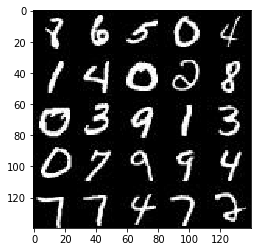

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

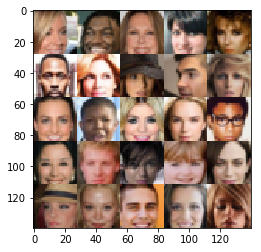

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/tapanm01/anaconda2/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='Real_Input')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='Z_input')
    learning_rate = tf.placeholder(tf.float32, name='Learning_Rate')

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)


    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01 * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.01 * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.01 * x3, x3)
        # 28x28x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)

    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    

    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2.0

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Steps {}    ".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Steps 10     Discriminator Loss: 10.8557... Generator Loss: 0.0000
Epoch 1/2... Steps 20     Discriminator Loss: 0.1175... Generator Loss: 9.2902
Epoch 1/2... Steps 30     Discriminator Loss: 0.8673... Generator Loss: 1.8374
Epoch 1/2... Steps 40     Discriminator Loss: 1.7637... Generator Loss: 4.0408
Epoch 1/2... Steps 50     Discriminator Loss: 0.4776... Generator Loss: 2.2018
Epoch 1/2... Steps 60     Discriminator Loss: 0.8938... Generator Loss: 1.7589
Epoch 1/2... Steps 70     Discriminator Loss: 1.5531... Generator Loss: 2.4285
Epoch 1/2... Steps 80     Discriminator Loss: 1.5927... Generator Loss: 1.7071
Epoch 1/2... Steps 90     Discriminator Loss: 1.7859... Generator Loss: 1.7034
Epoch 1/2... Steps 100     Discriminator Loss: 1.5327... Generator Loss: 1.1398


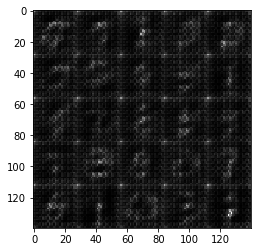

Epoch 1/2... Steps 110     Discriminator Loss: 1.5637... Generator Loss: 1.1359
Epoch 1/2... Steps 120     Discriminator Loss: 1.5214... Generator Loss: 1.3062
Epoch 1/2... Steps 130     Discriminator Loss: 1.6720... Generator Loss: 1.3192
Epoch 1/2... Steps 140     Discriminator Loss: 1.6609... Generator Loss: 0.9271
Epoch 1/2... Steps 150     Discriminator Loss: 1.4997... Generator Loss: 1.0697
Epoch 1/2... Steps 160     Discriminator Loss: 1.5856... Generator Loss: 1.0692
Epoch 1/2... Steps 170     Discriminator Loss: 1.4882... Generator Loss: 1.1292
Epoch 1/2... Steps 180     Discriminator Loss: 1.5166... Generator Loss: 1.0073
Epoch 1/2... Steps 190     Discriminator Loss: 1.5011... Generator Loss: 1.1356
Epoch 1/2... Steps 200     Discriminator Loss: 1.5664... Generator Loss: 0.9598


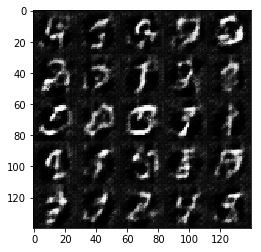

Epoch 1/2... Steps 210     Discriminator Loss: 1.4196... Generator Loss: 0.8852
Epoch 1/2... Steps 220     Discriminator Loss: 1.4571... Generator Loss: 1.0158
Epoch 1/2... Steps 230     Discriminator Loss: 1.4525... Generator Loss: 1.0727
Epoch 1/2... Steps 240     Discriminator Loss: 1.5385... Generator Loss: 1.0589
Epoch 1/2... Steps 250     Discriminator Loss: 1.5024... Generator Loss: 1.0930
Epoch 1/2... Steps 260     Discriminator Loss: 1.5797... Generator Loss: 1.0891
Epoch 1/2... Steps 270     Discriminator Loss: 1.4589... Generator Loss: 1.0992
Epoch 1/2... Steps 280     Discriminator Loss: 1.4285... Generator Loss: 1.0965
Epoch 1/2... Steps 290     Discriminator Loss: 1.4093... Generator Loss: 0.7257
Epoch 1/2... Steps 300     Discriminator Loss: 1.4361... Generator Loss: 1.1932


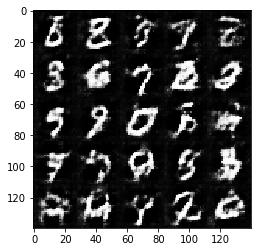

Epoch 1/2... Steps 310     Discriminator Loss: 1.4089... Generator Loss: 0.9911
Epoch 1/2... Steps 320     Discriminator Loss: 1.4134... Generator Loss: 0.9759
Epoch 1/2... Steps 330     Discriminator Loss: 1.4454... Generator Loss: 1.0371
Epoch 1/2... Steps 340     Discriminator Loss: 1.5069... Generator Loss: 0.9571
Epoch 1/2... Steps 350     Discriminator Loss: 1.4562... Generator Loss: 0.8027
Epoch 1/2... Steps 360     Discriminator Loss: 1.5979... Generator Loss: 1.2475
Epoch 1/2... Steps 370     Discriminator Loss: 1.4708... Generator Loss: 1.0257
Epoch 1/2... Steps 380     Discriminator Loss: 1.6112... Generator Loss: 1.2710
Epoch 1/2... Steps 390     Discriminator Loss: 1.4754... Generator Loss: 0.9449
Epoch 1/2... Steps 400     Discriminator Loss: 1.4703... Generator Loss: 0.9737


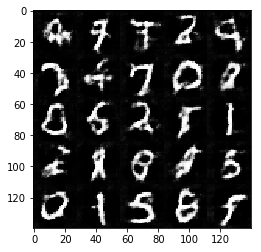

Epoch 1/2... Steps 410     Discriminator Loss: 1.4733... Generator Loss: 0.9776
Epoch 1/2... Steps 420     Discriminator Loss: 1.2770... Generator Loss: 0.9792
Epoch 1/2... Steps 430     Discriminator Loss: 1.4089... Generator Loss: 0.9896
Epoch 1/2... Steps 440     Discriminator Loss: 1.8193... Generator Loss: 1.4441
Epoch 1/2... Steps 450     Discriminator Loss: 1.3229... Generator Loss: 0.8700
Epoch 1/2... Steps 460     Discriminator Loss: 1.4087... Generator Loss: 0.9933
Epoch 1/2... Steps 470     Discriminator Loss: 1.4609... Generator Loss: 0.9479
Epoch 1/2... Steps 480     Discriminator Loss: 1.4364... Generator Loss: 0.9275
Epoch 1/2... Steps 490     Discriminator Loss: 1.3073... Generator Loss: 0.8114
Epoch 1/2... Steps 500     Discriminator Loss: 1.3372... Generator Loss: 0.9911


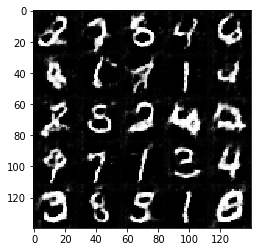

Epoch 1/2... Steps 510     Discriminator Loss: 1.8644... Generator Loss: 1.6580
Epoch 1/2... Steps 520     Discriminator Loss: 1.3488... Generator Loss: 0.5584
Epoch 1/2... Steps 530     Discriminator Loss: 1.5814... Generator Loss: 0.3159
Epoch 1/2... Steps 540     Discriminator Loss: 1.5160... Generator Loss: 0.3453
Epoch 1/2... Steps 550     Discriminator Loss: 1.6804... Generator Loss: 0.2833
Epoch 1/2... Steps 560     Discriminator Loss: 1.4248... Generator Loss: 0.4332
Epoch 1/2... Steps 570     Discriminator Loss: 1.7076... Generator Loss: 0.2821
Epoch 1/2... Steps 580     Discriminator Loss: 1.4580... Generator Loss: 0.4150
Epoch 1/2... Steps 590     Discriminator Loss: 1.3968... Generator Loss: 0.4376
Epoch 1/2... Steps 600     Discriminator Loss: 1.6990... Generator Loss: 0.2651


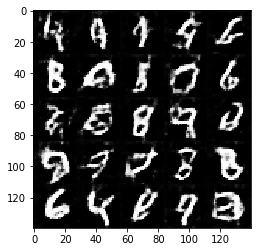

Epoch 1/2... Steps 610     Discriminator Loss: 1.4070... Generator Loss: 0.4361
Epoch 1/2... Steps 620     Discriminator Loss: 1.7143... Generator Loss: 0.2640
Epoch 1/2... Steps 630     Discriminator Loss: 1.3932... Generator Loss: 0.4391
Epoch 1/2... Steps 640     Discriminator Loss: 1.5607... Generator Loss: 0.3224
Epoch 1/2... Steps 650     Discriminator Loss: 1.5802... Generator Loss: 0.3272
Epoch 1/2... Steps 660     Discriminator Loss: 1.4582... Generator Loss: 0.3990
Epoch 1/2... Steps 670     Discriminator Loss: 1.6956... Generator Loss: 0.2674
Epoch 1/2... Steps 680     Discriminator Loss: 1.3809... Generator Loss: 0.4341
Epoch 1/2... Steps 690     Discriminator Loss: 1.4681... Generator Loss: 0.4299
Epoch 1/2... Steps 700     Discriminator Loss: 1.4300... Generator Loss: 0.4543


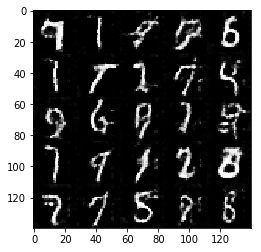

Epoch 1/2... Steps 710     Discriminator Loss: 1.4240... Generator Loss: 0.3943
Epoch 1/2... Steps 720     Discriminator Loss: 1.5954... Generator Loss: 0.3035
Epoch 1/2... Steps 730     Discriminator Loss: 1.4738... Generator Loss: 0.3549
Epoch 1/2... Steps 740     Discriminator Loss: 1.3847... Generator Loss: 0.4324
Epoch 1/2... Steps 750     Discriminator Loss: 1.4663... Generator Loss: 0.3808
Epoch 1/2... Steps 760     Discriminator Loss: 1.5206... Generator Loss: 0.3505
Epoch 1/2... Steps 770     Discriminator Loss: 1.5719... Generator Loss: 0.3190
Epoch 1/2... Steps 780     Discriminator Loss: 1.3428... Generator Loss: 0.5026
Epoch 1/2... Steps 790     Discriminator Loss: 1.5154... Generator Loss: 0.3283
Epoch 1/2... Steps 800     Discriminator Loss: 1.4950... Generator Loss: 0.3702


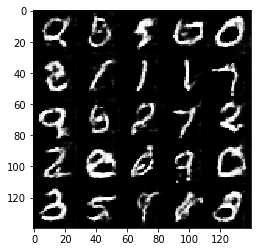

Epoch 1/2... Steps 810     Discriminator Loss: 1.3035... Generator Loss: 1.0276
Epoch 1/2... Steps 820     Discriminator Loss: 1.3595... Generator Loss: 0.9856
Epoch 1/2... Steps 830     Discriminator Loss: 1.3505... Generator Loss: 1.0274
Epoch 1/2... Steps 840     Discriminator Loss: 1.2423... Generator Loss: 1.1627
Epoch 1/2... Steps 850     Discriminator Loss: 1.3299... Generator Loss: 1.1365
Epoch 1/2... Steps 860     Discriminator Loss: 1.2541... Generator Loss: 1.1072
Epoch 1/2... Steps 870     Discriminator Loss: 1.2925... Generator Loss: 1.0898
Epoch 1/2... Steps 880     Discriminator Loss: 1.1473... Generator Loss: 0.6463
Epoch 1/2... Steps 890     Discriminator Loss: 1.6707... Generator Loss: 0.2967
Epoch 1/2... Steps 900     Discriminator Loss: 1.4034... Generator Loss: 0.4912


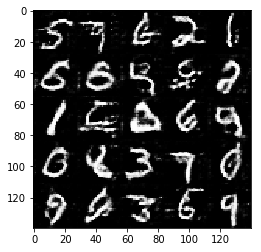

Epoch 1/2... Steps 910     Discriminator Loss: 1.4679... Generator Loss: 0.3871
Epoch 1/2... Steps 920     Discriminator Loss: 1.4195... Generator Loss: 0.3901
Epoch 1/2... Steps 930     Discriminator Loss: 1.3822... Generator Loss: 0.4169
Epoch 2/2... Steps 940     Discriminator Loss: 1.5683... Generator Loss: 0.3100
Epoch 2/2... Steps 950     Discriminator Loss: 1.3427... Generator Loss: 0.4991
Epoch 2/2... Steps 960     Discriminator Loss: 1.4331... Generator Loss: 0.3691
Epoch 2/2... Steps 970     Discriminator Loss: 1.3651... Generator Loss: 0.4696
Epoch 2/2... Steps 980     Discriminator Loss: 1.5036... Generator Loss: 0.4078
Epoch 2/2... Steps 990     Discriminator Loss: 1.4477... Generator Loss: 0.3612
Epoch 2/2... Steps 1000     Discriminator Loss: 1.4625... Generator Loss: 0.3990


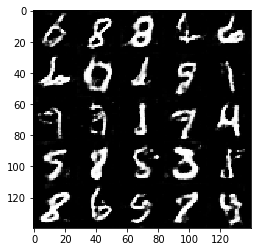

Epoch 2/2... Steps 1010     Discriminator Loss: 1.5446... Generator Loss: 0.3281
Epoch 2/2... Steps 1020     Discriminator Loss: 1.2704... Generator Loss: 0.5005
Epoch 2/2... Steps 1030     Discriminator Loss: 1.3153... Generator Loss: 0.5873
Epoch 2/2... Steps 1040     Discriminator Loss: 1.1368... Generator Loss: 0.7745
Epoch 2/2... Steps 1050     Discriminator Loss: 1.3694... Generator Loss: 1.1470
Epoch 2/2... Steps 1060     Discriminator Loss: 1.3456... Generator Loss: 0.9422
Epoch 2/2... Steps 1070     Discriminator Loss: 1.2330... Generator Loss: 0.9453
Epoch 2/2... Steps 1080     Discriminator Loss: 1.2806... Generator Loss: 0.7076
Epoch 2/2... Steps 1090     Discriminator Loss: 1.4010... Generator Loss: 1.0160
Epoch 2/2... Steps 1100     Discriminator Loss: 1.2651... Generator Loss: 1.0154


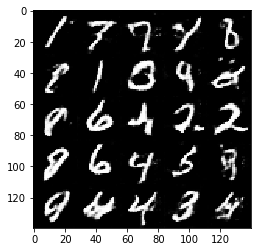

Epoch 2/2... Steps 1110     Discriminator Loss: 1.2620... Generator Loss: 1.1317
Epoch 2/2... Steps 1120     Discriminator Loss: 1.2435... Generator Loss: 1.1290
Epoch 2/2... Steps 1130     Discriminator Loss: 1.2206... Generator Loss: 1.1331
Epoch 2/2... Steps 1140     Discriminator Loss: 1.5508... Generator Loss: 1.5094
Epoch 2/2... Steps 1150     Discriminator Loss: 1.2294... Generator Loss: 0.9201
Epoch 2/2... Steps 1160     Discriminator Loss: 1.2003... Generator Loss: 0.6906
Epoch 2/2... Steps 1170     Discriminator Loss: 1.3782... Generator Loss: 0.4873
Epoch 2/2... Steps 1180     Discriminator Loss: 1.3953... Generator Loss: 0.4003
Epoch 2/2... Steps 1190     Discriminator Loss: 1.5689... Generator Loss: 0.3486
Epoch 2/2... Steps 1200     Discriminator Loss: 1.3153... Generator Loss: 0.6480


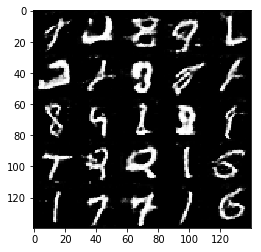

Epoch 2/2... Steps 1210     Discriminator Loss: 1.2916... Generator Loss: 0.8993
Epoch 2/2... Steps 1220     Discriminator Loss: 1.2832... Generator Loss: 0.6990
Epoch 2/2... Steps 1230     Discriminator Loss: 1.4828... Generator Loss: 1.4001
Epoch 2/2... Steps 1240     Discriminator Loss: 1.4518... Generator Loss: 1.3029
Epoch 2/2... Steps 1250     Discriminator Loss: 1.1816... Generator Loss: 0.6558
Epoch 2/2... Steps 1260     Discriminator Loss: 1.8112... Generator Loss: 0.2305
Epoch 2/2... Steps 1270     Discriminator Loss: 1.4611... Generator Loss: 0.3958
Epoch 2/2... Steps 1280     Discriminator Loss: 1.7201... Generator Loss: 0.2639
Epoch 2/2... Steps 1290     Discriminator Loss: 1.2160... Generator Loss: 1.1696
Epoch 2/2... Steps 1300     Discriminator Loss: 1.1020... Generator Loss: 1.1005


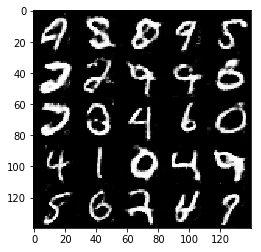

Epoch 2/2... Steps 1310     Discriminator Loss: 1.3312... Generator Loss: 1.3114
Epoch 2/2... Steps 1320     Discriminator Loss: 1.2759... Generator Loss: 1.1224
Epoch 2/2... Steps 1330     Discriminator Loss: 1.2514... Generator Loss: 0.7799
Epoch 2/2... Steps 1340     Discriminator Loss: 1.1645... Generator Loss: 0.9646
Epoch 2/2... Steps 1350     Discriminator Loss: 1.4823... Generator Loss: 1.2697
Epoch 2/2... Steps 1360     Discriminator Loss: 1.2447... Generator Loss: 0.5590
Epoch 2/2... Steps 1370     Discriminator Loss: 1.5327... Generator Loss: 0.3317
Epoch 2/2... Steps 1380     Discriminator Loss: 1.4387... Generator Loss: 0.3558
Epoch 2/2... Steps 1390     Discriminator Loss: 1.4795... Generator Loss: 0.3818
Epoch 2/2... Steps 1400     Discriminator Loss: 1.4909... Generator Loss: 0.3796


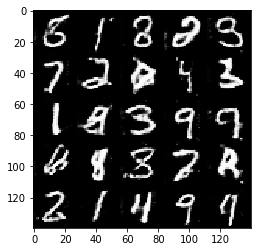

Epoch 2/2... Steps 1410     Discriminator Loss: 1.4349... Generator Loss: 0.3775
Epoch 2/2... Steps 1420     Discriminator Loss: 1.4218... Generator Loss: 0.3714
Epoch 2/2... Steps 1430     Discriminator Loss: 1.2627... Generator Loss: 0.4611
Epoch 2/2... Steps 1440     Discriminator Loss: 2.0382... Generator Loss: 0.1965
Epoch 2/2... Steps 1450     Discriminator Loss: 1.4815... Generator Loss: 0.3796
Epoch 2/2... Steps 1460     Discriminator Loss: 1.3847... Generator Loss: 0.4246
Epoch 2/2... Steps 1470     Discriminator Loss: 1.5042... Generator Loss: 0.3227
Epoch 2/2... Steps 1480     Discriminator Loss: 1.4542... Generator Loss: 0.3886
Epoch 2/2... Steps 1490     Discriminator Loss: 1.2773... Generator Loss: 0.6628
Epoch 2/2... Steps 1500     Discriminator Loss: 1.2177... Generator Loss: 1.0232


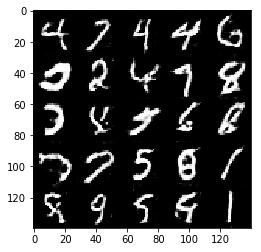

Epoch 2/2... Steps 1510     Discriminator Loss: 1.1296... Generator Loss: 1.2721
Epoch 2/2... Steps 1520     Discriminator Loss: 1.3066... Generator Loss: 0.9155
Epoch 2/2... Steps 1530     Discriminator Loss: 1.1536... Generator Loss: 0.7730
Epoch 2/2... Steps 1540     Discriminator Loss: 1.1241... Generator Loss: 1.2965
Epoch 2/2... Steps 1550     Discriminator Loss: 1.1785... Generator Loss: 0.7791
Epoch 2/2... Steps 1560     Discriminator Loss: 1.3112... Generator Loss: 0.9487
Epoch 2/2... Steps 1570     Discriminator Loss: 1.2115... Generator Loss: 1.0624
Epoch 2/2... Steps 1580     Discriminator Loss: 1.0075... Generator Loss: 0.9453
Epoch 2/2... Steps 1590     Discriminator Loss: 1.2682... Generator Loss: 0.5527
Epoch 2/2... Steps 1600     Discriminator Loss: 1.2321... Generator Loss: 0.6704


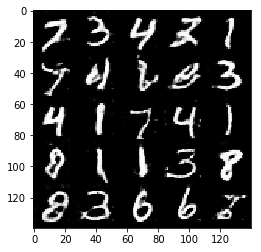

Epoch 2/2... Steps 1610     Discriminator Loss: 1.3451... Generator Loss: 0.4248
Epoch 2/2... Steps 1620     Discriminator Loss: 1.5324... Generator Loss: 0.3414
Epoch 2/2... Steps 1630     Discriminator Loss: 1.1662... Generator Loss: 0.5833
Epoch 2/2... Steps 1640     Discriminator Loss: 1.3297... Generator Loss: 0.4428
Epoch 2/2... Steps 1650     Discriminator Loss: 1.5831... Generator Loss: 0.3257
Epoch 2/2... Steps 1660     Discriminator Loss: 1.4843... Generator Loss: 0.3682
Epoch 2/2... Steps 1670     Discriminator Loss: 1.6472... Generator Loss: 0.2740
Epoch 2/2... Steps 1680     Discriminator Loss: 1.2713... Generator Loss: 0.6563
Epoch 2/2... Steps 1690     Discriminator Loss: 1.1404... Generator Loss: 0.9346
Epoch 2/2... Steps 1700     Discriminator Loss: 1.1943... Generator Loss: 0.9606


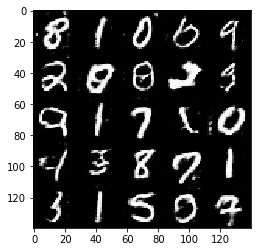

Epoch 2/2... Steps 1710     Discriminator Loss: 1.2102... Generator Loss: 1.1925
Epoch 2/2... Steps 1720     Discriminator Loss: 1.2755... Generator Loss: 1.3228
Epoch 2/2... Steps 1730     Discriminator Loss: 0.9573... Generator Loss: 1.0666
Epoch 2/2... Steps 1740     Discriminator Loss: 1.0529... Generator Loss: 0.8084
Epoch 2/2... Steps 1750     Discriminator Loss: 1.4634... Generator Loss: 0.3619
Epoch 2/2... Steps 1760     Discriminator Loss: 1.6299... Generator Loss: 0.2871
Epoch 2/2... Steps 1770     Discriminator Loss: 1.2999... Generator Loss: 0.5746
Epoch 2/2... Steps 1780     Discriminator Loss: 1.4346... Generator Loss: 0.4274
Epoch 2/2... Steps 1790     Discriminator Loss: 1.6028... Generator Loss: 0.3846
Epoch 2/2... Steps 1800     Discriminator Loss: 1.5436... Generator Loss: 0.3900


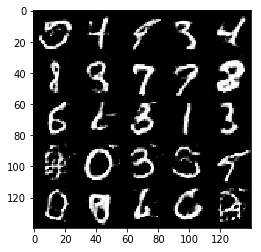

Epoch 2/2... Steps 1810     Discriminator Loss: 1.4373... Generator Loss: 0.3957
Epoch 2/2... Steps 1820     Discriminator Loss: 1.6715... Generator Loss: 0.2672
Epoch 2/2... Steps 1830     Discriminator Loss: 1.6144... Generator Loss: 0.3060
Epoch 2/2... Steps 1840     Discriminator Loss: 1.3427... Generator Loss: 0.4054
Epoch 2/2... Steps 1850     Discriminator Loss: 1.3639... Generator Loss: 0.4099
Epoch 2/2... Steps 1860     Discriminator Loss: 1.5891... Generator Loss: 0.3005
Epoch 2/2... Steps 1870     Discriminator Loss: 1.3864... Generator Loss: 0.3985


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Steps 10     Discriminator Loss: 1.1179... Generator Loss: 9.4250
Epoch 1/1... Steps 20     Discriminator Loss: 1.4989... Generator Loss: 9.4898
Epoch 1/1... Steps 30     Discriminator Loss: 1.5050... Generator Loss: 2.1011
Epoch 1/1... Steps 40     Discriminator Loss: 1.1252... Generator Loss: 1.5048
Epoch 1/1... Steps 50     Discriminator Loss: 1.2048... Generator Loss: 0.7584
Epoch 1/1... Steps 60     Discriminator Loss: 1.5222... Generator Loss: 0.3449
Epoch 1/1... Steps 70     Discriminator Loss: 0.8587... Generator Loss: 0.9915
Epoch 1/1... Steps 80     Discriminator Loss: 2.4455... Generator Loss: 2.8182
Epoch 1/1... Steps 90     Discriminator Loss: 0.5866... Generator Loss: 1.1314
Epoch 1/1... Steps 100     Discriminator Loss: 1.2044... Generator Loss: 0.7858


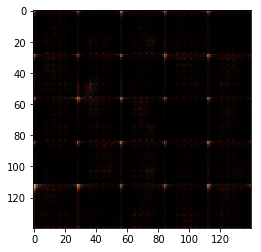

Epoch 1/1... Steps 110     Discriminator Loss: 3.0110... Generator Loss: 3.0332
Epoch 1/1... Steps 120     Discriminator Loss: 0.4792... Generator Loss: 2.2132
Epoch 1/1... Steps 130     Discriminator Loss: 0.2973... Generator Loss: 1.7042
Epoch 1/1... Steps 140     Discriminator Loss: 0.9433... Generator Loss: 3.5499
Epoch 1/1... Steps 150     Discriminator Loss: 0.9951... Generator Loss: 0.7477
Epoch 1/1... Steps 160     Discriminator Loss: 0.4148... Generator Loss: 1.2222
Epoch 1/1... Steps 170     Discriminator Loss: 1.7594... Generator Loss: 2.1807
Epoch 1/1... Steps 180     Discriminator Loss: 0.4601... Generator Loss: 1.2516
Epoch 1/1... Steps 190     Discriminator Loss: 1.6108... Generator Loss: 1.1422
Epoch 1/1... Steps 200     Discriminator Loss: 0.6343... Generator Loss: 2.6592


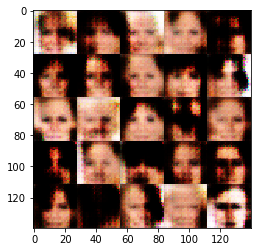

Epoch 1/1... Steps 210     Discriminator Loss: 0.4331... Generator Loss: 1.5222
Epoch 1/1... Steps 220     Discriminator Loss: 0.0913... Generator Loss: 3.9855
Epoch 1/1... Steps 230     Discriminator Loss: 0.1308... Generator Loss: 3.5089
Epoch 1/1... Steps 240     Discriminator Loss: 0.0873... Generator Loss: 3.3875
Epoch 1/1... Steps 250     Discriminator Loss: 0.2067... Generator Loss: 2.0846
Epoch 1/1... Steps 260     Discriminator Loss: 0.3261... Generator Loss: 1.6002
Epoch 1/1... Steps 270     Discriminator Loss: 1.3144... Generator Loss: 1.0219
Epoch 1/1... Steps 280     Discriminator Loss: 1.2124... Generator Loss: 0.6432
Epoch 1/1... Steps 290     Discriminator Loss: 0.9413... Generator Loss: 0.8232
Epoch 1/1... Steps 300     Discriminator Loss: 1.1838... Generator Loss: 1.0178


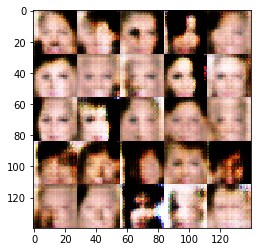

Epoch 1/1... Steps 310     Discriminator Loss: 1.2993... Generator Loss: 0.7539
Epoch 1/1... Steps 320     Discriminator Loss: 1.2528... Generator Loss: 0.4721
Epoch 1/1... Steps 330     Discriminator Loss: 1.0405... Generator Loss: 0.6155
Epoch 1/1... Steps 340     Discriminator Loss: 1.2813... Generator Loss: 0.9881
Epoch 1/1... Steps 350     Discriminator Loss: 1.1735... Generator Loss: 0.9767
Epoch 1/1... Steps 360     Discriminator Loss: 1.1172... Generator Loss: 0.8140
Epoch 1/1... Steps 370     Discriminator Loss: 1.4348... Generator Loss: 0.3660
Epoch 1/1... Steps 380     Discriminator Loss: 1.0172... Generator Loss: 0.5826
Epoch 1/1... Steps 390     Discriminator Loss: 1.0220... Generator Loss: 0.8574
Epoch 1/1... Steps 400     Discriminator Loss: 0.9895... Generator Loss: 2.3944


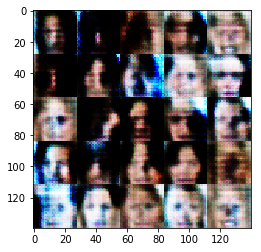

Epoch 1/1... Steps 410     Discriminator Loss: 0.3133... Generator Loss: 1.5806
Epoch 1/1... Steps 420     Discriminator Loss: 0.0947... Generator Loss: 3.5096
Epoch 1/1... Steps 430     Discriminator Loss: 0.3461... Generator Loss: 1.4776
Epoch 1/1... Steps 440     Discriminator Loss: 0.1565... Generator Loss: 2.2574
Epoch 1/1... Steps 450     Discriminator Loss: 0.0200... Generator Loss: 4.5783
Epoch 1/1... Steps 460     Discriminator Loss: 0.1134... Generator Loss: 2.6359
Epoch 1/1... Steps 470     Discriminator Loss: 0.0310... Generator Loss: 4.3825
Epoch 1/1... Steps 480     Discriminator Loss: 0.0488... Generator Loss: 3.4072
Epoch 1/1... Steps 490     Discriminator Loss: 1.2776... Generator Loss: 0.9235
Epoch 1/1... Steps 500     Discriminator Loss: 0.9363... Generator Loss: 0.8571


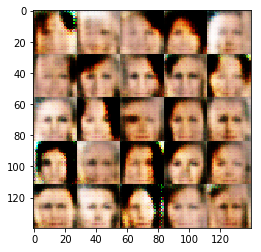

Epoch 1/1... Steps 510     Discriminator Loss: 1.1901... Generator Loss: 0.4701
Epoch 1/1... Steps 520     Discriminator Loss: 0.8970... Generator Loss: 0.7493
Epoch 1/1... Steps 530     Discriminator Loss: 1.6211... Generator Loss: 0.2970
Epoch 1/1... Steps 540     Discriminator Loss: 1.0244... Generator Loss: 0.5896
Epoch 1/1... Steps 550     Discriminator Loss: 1.6489... Generator Loss: 3.1393
Epoch 1/1... Steps 560     Discriminator Loss: 1.1498... Generator Loss: 1.7524
Epoch 1/1... Steps 570     Discriminator Loss: 0.2143... Generator Loss: 2.0158
Epoch 1/1... Steps 580     Discriminator Loss: 1.5595... Generator Loss: 0.3673
Epoch 1/1... Steps 590     Discriminator Loss: 1.8018... Generator Loss: 0.2385
Epoch 1/1... Steps 600     Discriminator Loss: 1.1736... Generator Loss: 0.4831


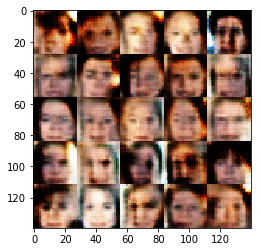

Epoch 1/1... Steps 610     Discriminator Loss: 1.3558... Generator Loss: 0.3468
Epoch 1/1... Steps 620     Discriminator Loss: 0.4331... Generator Loss: 1.5227
Epoch 1/1... Steps 630     Discriminator Loss: 1.1940... Generator Loss: 0.6224
Epoch 1/1... Steps 640     Discriminator Loss: 1.4450... Generator Loss: 0.4313
Epoch 1/1... Steps 650     Discriminator Loss: 0.9119... Generator Loss: 0.6301
Epoch 1/1... Steps 660     Discriminator Loss: 1.0735... Generator Loss: 1.0763
Epoch 1/1... Steps 670     Discriminator Loss: 0.4979... Generator Loss: 1.2860
Epoch 1/1... Steps 680     Discriminator Loss: 1.7696... Generator Loss: 0.2207
Epoch 1/1... Steps 690     Discriminator Loss: 0.1613... Generator Loss: 2.0529
Epoch 1/1... Steps 700     Discriminator Loss: 0.6687... Generator Loss: 1.3109


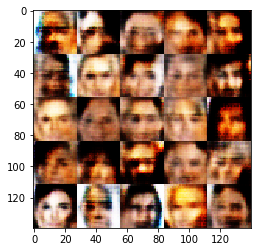

Epoch 1/1... Steps 710     Discriminator Loss: 0.0649... Generator Loss: 2.9637
Epoch 1/1... Steps 720     Discriminator Loss: 0.5964... Generator Loss: 1.0787
Epoch 1/1... Steps 730     Discriminator Loss: 1.4058... Generator Loss: 0.4030
Epoch 1/1... Steps 740     Discriminator Loss: 0.1280... Generator Loss: 2.5354
Epoch 1/1... Steps 750     Discriminator Loss: 1.3112... Generator Loss: 1.1464
Epoch 1/1... Steps 760     Discriminator Loss: 1.0726... Generator Loss: 1.5455
Epoch 1/1... Steps 770     Discriminator Loss: 0.4897... Generator Loss: 2.9713
Epoch 1/1... Steps 780     Discriminator Loss: 0.2802... Generator Loss: 1.9523
Epoch 1/1... Steps 790     Discriminator Loss: 1.4559... Generator Loss: 0.3568
Epoch 1/1... Steps 800     Discriminator Loss: 0.8657... Generator Loss: 0.9232


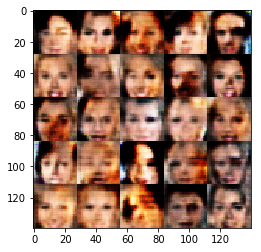

Epoch 1/1... Steps 810     Discriminator Loss: 0.9942... Generator Loss: 2.4825
Epoch 1/1... Steps 820     Discriminator Loss: 1.5828... Generator Loss: 1.5378
Epoch 1/1... Steps 830     Discriminator Loss: 0.7098... Generator Loss: 2.0916
Epoch 1/1... Steps 840     Discriminator Loss: 0.4873... Generator Loss: 1.5969
Epoch 1/1... Steps 850     Discriminator Loss: 2.5678... Generator Loss: 2.8174
Epoch 1/1... Steps 860     Discriminator Loss: 0.2260... Generator Loss: 2.0039
Epoch 1/1... Steps 870     Discriminator Loss: 0.0464... Generator Loss: 3.8546
Epoch 1/1... Steps 880     Discriminator Loss: 0.2205... Generator Loss: 1.8912
Epoch 1/1... Steps 890     Discriminator Loss: 0.0182... Generator Loss: 5.3807
Epoch 1/1... Steps 900     Discriminator Loss: 0.0627... Generator Loss: 3.1499


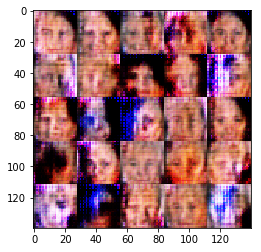

Epoch 1/1... Steps 910     Discriminator Loss: 0.0645... Generator Loss: 3.4258
Epoch 1/1... Steps 920     Discriminator Loss: 0.0990... Generator Loss: 2.6967
Epoch 1/1... Steps 930     Discriminator Loss: 0.0257... Generator Loss: 4.2820
Epoch 1/1... Steps 940     Discriminator Loss: 0.0575... Generator Loss: 3.1857
Epoch 1/1... Steps 950     Discriminator Loss: 0.0287... Generator Loss: 4.1753
Epoch 1/1... Steps 960     Discriminator Loss: 0.0253... Generator Loss: 4.6017
Epoch 1/1... Steps 970     Discriminator Loss: 2.6598... Generator Loss: 1.9649
Epoch 1/1... Steps 980     Discriminator Loss: 1.6237... Generator Loss: 2.5392
Epoch 1/1... Steps 990     Discriminator Loss: 1.3088... Generator Loss: 1.3489
Epoch 1/1... Steps 1000     Discriminator Loss: 1.2488... Generator Loss: 2.2865


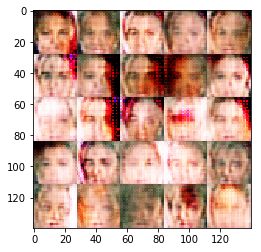

Epoch 1/1... Steps 1010     Discriminator Loss: 1.2469... Generator Loss: 0.9477
Epoch 1/1... Steps 1020     Discriminator Loss: 1.4361... Generator Loss: 2.0386
Epoch 1/1... Steps 1030     Discriminator Loss: 0.8694... Generator Loss: 1.1082
Epoch 1/1... Steps 1040     Discriminator Loss: 1.3232... Generator Loss: 1.2665
Epoch 1/1... Steps 1050     Discriminator Loss: 2.5592... Generator Loss: 3.3797
Epoch 1/1... Steps 1060     Discriminator Loss: 1.3934... Generator Loss: 2.3254
Epoch 1/1... Steps 1070     Discriminator Loss: 1.2254... Generator Loss: 1.4262
Epoch 1/1... Steps 1080     Discriminator Loss: 1.6361... Generator Loss: 2.3921
Epoch 1/1... Steps 1090     Discriminator Loss: 2.1736... Generator Loss: 1.0272
Epoch 1/1... Steps 1100     Discriminator Loss: 1.3960... Generator Loss: 0.7403


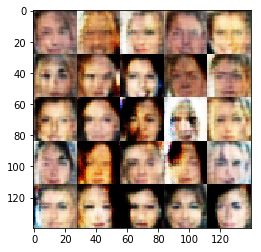

Epoch 1/1... Steps 1110     Discriminator Loss: 1.2259... Generator Loss: 0.5643
Epoch 1/1... Steps 1120     Discriminator Loss: 1.1705... Generator Loss: 0.5633
Epoch 1/1... Steps 1130     Discriminator Loss: 1.1588... Generator Loss: 0.4902
Epoch 1/1... Steps 1140     Discriminator Loss: 1.3157... Generator Loss: 0.8366
Epoch 1/1... Steps 1150     Discriminator Loss: 1.1365... Generator Loss: 0.8445
Epoch 1/1... Steps 1160     Discriminator Loss: 1.1004... Generator Loss: 0.9225
Epoch 1/1... Steps 1170     Discriminator Loss: 1.2646... Generator Loss: 0.4695
Epoch 1/1... Steps 1180     Discriminator Loss: 1.0550... Generator Loss: 0.7356
Epoch 1/1... Steps 1190     Discriminator Loss: 1.7311... Generator Loss: 0.2541
Epoch 1/1... Steps 1200     Discriminator Loss: 0.7829... Generator Loss: 0.7860


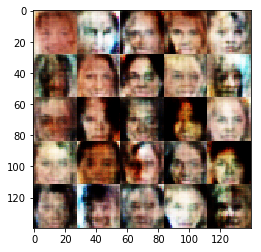

Epoch 1/1... Steps 1210     Discriminator Loss: 1.1894... Generator Loss: 0.6016
Epoch 1/1... Steps 1220     Discriminator Loss: 2.8873... Generator Loss: 2.7589
Epoch 1/1... Steps 1230     Discriminator Loss: 0.5570... Generator Loss: 0.9762
Epoch 1/1... Steps 1240     Discriminator Loss: 0.1644... Generator Loss: 2.6707
Epoch 1/1... Steps 1250     Discriminator Loss: 0.2043... Generator Loss: 1.9833
Epoch 1/1... Steps 1260     Discriminator Loss: 0.0617... Generator Loss: 3.3206
Epoch 1/1... Steps 1270     Discriminator Loss: 0.0458... Generator Loss: 3.8031
Epoch 1/1... Steps 1280     Discriminator Loss: 0.0569... Generator Loss: 3.9448
Epoch 1/1... Steps 1290     Discriminator Loss: 1.0890... Generator Loss: 0.6176
Epoch 1/1... Steps 1300     Discriminator Loss: 1.6663... Generator Loss: 0.3061


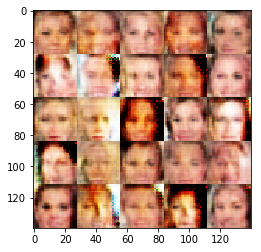

Epoch 1/1... Steps 1310     Discriminator Loss: 1.1517... Generator Loss: 0.6737
Epoch 1/1... Steps 1320     Discriminator Loss: 1.5351... Generator Loss: 0.3483
Epoch 1/1... Steps 1330     Discriminator Loss: 1.1707... Generator Loss: 0.5950
Epoch 1/1... Steps 1340     Discriminator Loss: 1.3798... Generator Loss: 0.3929
Epoch 1/1... Steps 1350     Discriminator Loss: 1.5844... Generator Loss: 0.3141
Epoch 1/1... Steps 1360     Discriminator Loss: 1.4512... Generator Loss: 0.3728
Epoch 1/1... Steps 1370     Discriminator Loss: 1.9827... Generator Loss: 0.2087
Epoch 1/1... Steps 1380     Discriminator Loss: 1.3846... Generator Loss: 0.6425
Epoch 1/1... Steps 1390     Discriminator Loss: 1.3916... Generator Loss: 0.4250
Epoch 1/1... Steps 1400     Discriminator Loss: 1.1431... Generator Loss: 0.5999


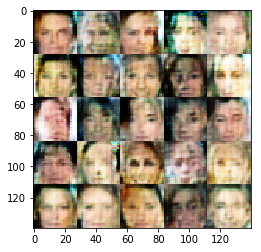

Epoch 1/1... Steps 1410     Discriminator Loss: 1.4083... Generator Loss: 0.3494
Epoch 1/1... Steps 1420     Discriminator Loss: 1.8027... Generator Loss: 0.2135
Epoch 1/1... Steps 1430     Discriminator Loss: 1.1318... Generator Loss: 0.5738
Epoch 1/1... Steps 1440     Discriminator Loss: 0.7384... Generator Loss: 1.2361
Epoch 1/1... Steps 1450     Discriminator Loss: 1.2410... Generator Loss: 0.7020
Epoch 1/1... Steps 1460     Discriminator Loss: 1.5141... Generator Loss: 0.3522
Epoch 1/1... Steps 1470     Discriminator Loss: 2.4820... Generator Loss: 0.1091
Epoch 1/1... Steps 1480     Discriminator Loss: 1.2998... Generator Loss: 1.0042
Epoch 1/1... Steps 1490     Discriminator Loss: 0.5457... Generator Loss: 1.3796
Epoch 1/1... Steps 1500     Discriminator Loss: 1.2470... Generator Loss: 1.8949


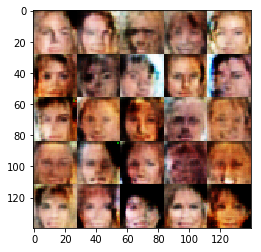

Epoch 1/1... Steps 1510     Discriminator Loss: 0.1708... Generator Loss: 2.2001
Epoch 1/1... Steps 1520     Discriminator Loss: 0.6217... Generator Loss: 1.8125
Epoch 1/1... Steps 1530     Discriminator Loss: 0.4759... Generator Loss: 1.2004
Epoch 1/1... Steps 1540     Discriminator Loss: 1.1252... Generator Loss: 1.1078
Epoch 1/1... Steps 1550     Discriminator Loss: 1.2751... Generator Loss: 0.4664
Epoch 1/1... Steps 1560     Discriminator Loss: 1.0800... Generator Loss: 0.5148
Epoch 1/1... Steps 1570     Discriminator Loss: 0.5967... Generator Loss: 1.9984
Epoch 1/1... Steps 1580     Discriminator Loss: 0.1145... Generator Loss: 2.8855
Epoch 1/1... Steps 1590     Discriminator Loss: 0.9116... Generator Loss: 0.6985
Epoch 1/1... Steps 1600     Discriminator Loss: 1.0190... Generator Loss: 1.3990


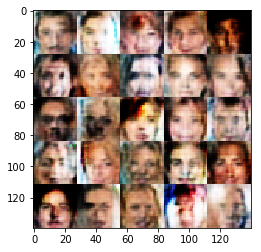

Epoch 1/1... Steps 1610     Discriminator Loss: 0.3490... Generator Loss: 1.4386
Epoch 1/1... Steps 1620     Discriminator Loss: 1.2492... Generator Loss: 0.9159
Epoch 1/1... Steps 1630     Discriminator Loss: 1.1971... Generator Loss: 0.8142
Epoch 1/1... Steps 1640     Discriminator Loss: 1.4037... Generator Loss: 2.4163
Epoch 1/1... Steps 1650     Discriminator Loss: 0.5153... Generator Loss: 1.3525
Epoch 1/1... Steps 1660     Discriminator Loss: 0.7062... Generator Loss: 1.9515
Epoch 1/1... Steps 1670     Discriminator Loss: 0.4486... Generator Loss: 2.3640
Epoch 1/1... Steps 1680     Discriminator Loss: 0.3822... Generator Loss: 1.3639
Epoch 1/1... Steps 1690     Discriminator Loss: 0.0667... Generator Loss: 3.4164
Epoch 1/1... Steps 1700     Discriminator Loss: 0.0966... Generator Loss: 2.7742


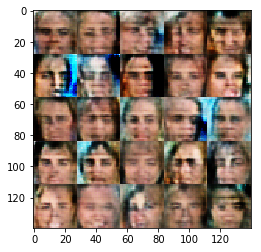

Epoch 1/1... Steps 1710     Discriminator Loss: 0.0844... Generator Loss: 2.7906
Epoch 1/1... Steps 1720     Discriminator Loss: 0.0661... Generator Loss: 3.0342
Epoch 1/1... Steps 1730     Discriminator Loss: 0.0563... Generator Loss: 4.9354
Epoch 1/1... Steps 1740     Discriminator Loss: 0.0546... Generator Loss: 3.4881
Epoch 1/1... Steps 1750     Discriminator Loss: 0.0601... Generator Loss: 3.3593
Epoch 1/1... Steps 1760     Discriminator Loss: 0.0413... Generator Loss: 3.5653
Epoch 1/1... Steps 1770     Discriminator Loss: 0.0478... Generator Loss: 3.3892
Epoch 1/1... Steps 1780     Discriminator Loss: 0.0307... Generator Loss: 3.7310
Epoch 1/1... Steps 1790     Discriminator Loss: 0.0440... Generator Loss: 3.2821
Epoch 1/1... Steps 1800     Discriminator Loss: 0.0554... Generator Loss: 3.3310


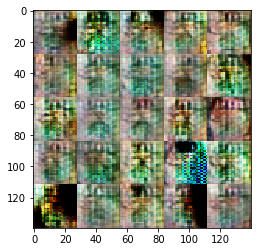

Epoch 1/1... Steps 1810     Discriminator Loss: 0.0665... Generator Loss: 3.1469
Epoch 1/1... Steps 1820     Discriminator Loss: 0.0452... Generator Loss: 3.4595
Epoch 1/1... Steps 1830     Discriminator Loss: 0.0318... Generator Loss: 3.7422
Epoch 1/1... Steps 1840     Discriminator Loss: 0.0258... Generator Loss: 3.9686
Epoch 1/1... Steps 1850     Discriminator Loss: 0.0151... Generator Loss: 4.3484
Epoch 1/1... Steps 1860     Discriminator Loss: 0.0185... Generator Loss: 4.1995
Epoch 1/1... Steps 1870     Discriminator Loss: 0.0150... Generator Loss: 4.4089
Epoch 1/1... Steps 1880     Discriminator Loss: 0.0052... Generator Loss: 5.6666
Epoch 1/1... Steps 1890     Discriminator Loss: 0.0130... Generator Loss: 4.7429
Epoch 1/1... Steps 1900     Discriminator Loss: 0.0024... Generator Loss: 8.4779


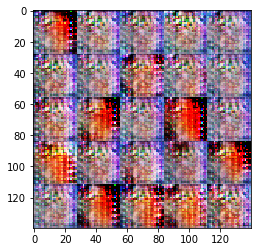

Epoch 1/1... Steps 1910     Discriminator Loss: 0.0049... Generator Loss: 5.8802
Epoch 1/1... Steps 1920     Discriminator Loss: 0.0044... Generator Loss: 7.4200
Epoch 1/1... Steps 1930     Discriminator Loss: 0.0027... Generator Loss: 8.9765
Epoch 1/1... Steps 1940     Discriminator Loss: 0.0049... Generator Loss: 6.7723
Epoch 1/1... Steps 1950     Discriminator Loss: 0.0148... Generator Loss: 4.5353
Epoch 1/1... Steps 1960     Discriminator Loss: 0.0023... Generator Loss: 9.8270
Epoch 1/1... Steps 1970     Discriminator Loss: 0.0042... Generator Loss: 6.6007
Epoch 1/1... Steps 1980     Discriminator Loss: 0.0038... Generator Loss: 7.1836
Epoch 1/1... Steps 1990     Discriminator Loss: 0.0075... Generator Loss: 5.4280
Epoch 1/1... Steps 2000     Discriminator Loss: 0.0330... Generator Loss: 3.6763


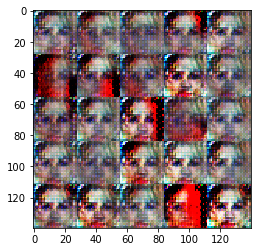

Epoch 1/1... Steps 2010     Discriminator Loss: 0.0043... Generator Loss: 8.7627
Epoch 1/1... Steps 2020     Discriminator Loss: 0.0368... Generator Loss: 3.6078
Epoch 1/1... Steps 2030     Discriminator Loss: 0.0068... Generator Loss: 5.8728
Epoch 1/1... Steps 2040     Discriminator Loss: 0.0156... Generator Loss: 6.1625
Epoch 1/1... Steps 2050     Discriminator Loss: 0.0051... Generator Loss: 9.0408
Epoch 1/1... Steps 2060     Discriminator Loss: 0.1016... Generator Loss: 2.7991
Epoch 1/1... Steps 2070     Discriminator Loss: 0.8567... Generator Loss: 5.4692
Epoch 1/1... Steps 2080     Discriminator Loss: 0.3194... Generator Loss: 1.7604
Epoch 1/1... Steps 2090     Discriminator Loss: 0.1621... Generator Loss: 2.7155
Epoch 1/1... Steps 2100     Discriminator Loss: 2.7071... Generator Loss: 0.1203


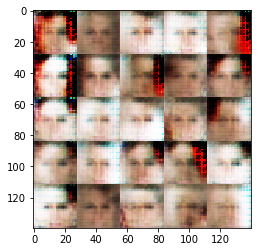

Epoch 1/1... Steps 2110     Discriminator Loss: 0.9981... Generator Loss: 0.6780
Epoch 1/1... Steps 2120     Discriminator Loss: 0.7883... Generator Loss: 2.3719
Epoch 1/1... Steps 2130     Discriminator Loss: 2.0487... Generator Loss: 4.1350
Epoch 1/1... Steps 2140     Discriminator Loss: 1.1913... Generator Loss: 4.8927
Epoch 1/1... Steps 2150     Discriminator Loss: 0.4962... Generator Loss: 1.1616
Epoch 1/1... Steps 2160     Discriminator Loss: 2.0883... Generator Loss: 0.1827
Epoch 1/1... Steps 2170     Discriminator Loss: 1.2142... Generator Loss: 1.9248
Epoch 1/1... Steps 2180     Discriminator Loss: 1.4554... Generator Loss: 0.4074
Epoch 1/1... Steps 2190     Discriminator Loss: 0.3782... Generator Loss: 1.6277
Epoch 1/1... Steps 2200     Discriminator Loss: 0.3768... Generator Loss: 1.5145


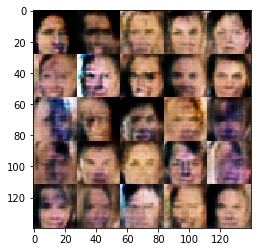

Epoch 1/1... Steps 2210     Discriminator Loss: 4.2695... Generator Loss: 4.5545
Epoch 1/1... Steps 2220     Discriminator Loss: 1.2034... Generator Loss: 0.9470
Epoch 1/1... Steps 2230     Discriminator Loss: 1.1176... Generator Loss: 2.3262
Epoch 1/1... Steps 2240     Discriminator Loss: 2.1460... Generator Loss: 2.9681
Epoch 1/1... Steps 2250     Discriminator Loss: 1.8783... Generator Loss: 2.7655
Epoch 1/1... Steps 2260     Discriminator Loss: 1.0389... Generator Loss: 0.7487
Epoch 1/1... Steps 2270     Discriminator Loss: 1.4652... Generator Loss: 0.3229
Epoch 1/1... Steps 2280     Discriminator Loss: 1.2720... Generator Loss: 0.4467
Epoch 1/1... Steps 2290     Discriminator Loss: 1.4365... Generator Loss: 0.3891
Epoch 1/1... Steps 2300     Discriminator Loss: 1.0987... Generator Loss: 0.5472


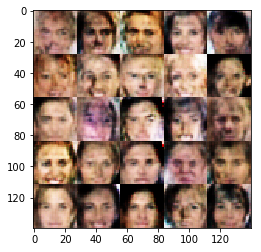

Epoch 1/1... Steps 2310     Discriminator Loss: 0.8175... Generator Loss: 1.0340
Epoch 1/1... Steps 2320     Discriminator Loss: 0.4331... Generator Loss: 1.4116
Epoch 1/1... Steps 2330     Discriminator Loss: 0.7454... Generator Loss: 0.8313
Epoch 1/1... Steps 2340     Discriminator Loss: 0.6985... Generator Loss: 1.3061
Epoch 1/1... Steps 2350     Discriminator Loss: 0.1920... Generator Loss: 2.3863
Epoch 1/1... Steps 2360     Discriminator Loss: 0.4644... Generator Loss: 1.3148
Epoch 1/1... Steps 2370     Discriminator Loss: 0.9726... Generator Loss: 2.7726
Epoch 1/1... Steps 2380     Discriminator Loss: 0.8903... Generator Loss: 0.7287
Epoch 1/1... Steps 2390     Discriminator Loss: 0.6785... Generator Loss: 1.5219
Epoch 1/1... Steps 2400     Discriminator Loss: 1.3083... Generator Loss: 0.6295


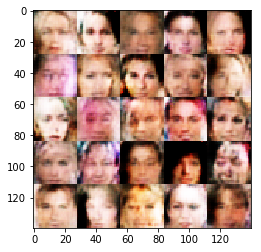

Epoch 1/1... Steps 2410     Discriminator Loss: 0.8093... Generator Loss: 0.7813
Epoch 1/1... Steps 2420     Discriminator Loss: 0.2003... Generator Loss: 2.4625
Epoch 1/1... Steps 2430     Discriminator Loss: 1.3832... Generator Loss: 1.6914
Epoch 1/1... Steps 2440     Discriminator Loss: 1.1290... Generator Loss: 0.7435
Epoch 1/1... Steps 2450     Discriminator Loss: 1.2576... Generator Loss: 0.5041
Epoch 1/1... Steps 2460     Discriminator Loss: 1.3867... Generator Loss: 0.4109
Epoch 1/1... Steps 2470     Discriminator Loss: 0.8577... Generator Loss: 1.2581
Epoch 1/1... Steps 2480     Discriminator Loss: 0.8604... Generator Loss: 0.6766
Epoch 1/1... Steps 2490     Discriminator Loss: 1.1169... Generator Loss: 1.9925
Epoch 1/1... Steps 2500     Discriminator Loss: 1.4811... Generator Loss: 2.0780


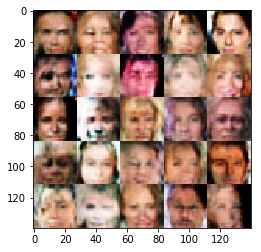

Epoch 1/1... Steps 2510     Discriminator Loss: 0.7005... Generator Loss: 0.8756
Epoch 1/1... Steps 2520     Discriminator Loss: 1.0342... Generator Loss: 0.6181
Epoch 1/1... Steps 2530     Discriminator Loss: 1.1433... Generator Loss: 0.9214
Epoch 1/1... Steps 2540     Discriminator Loss: 0.3352... Generator Loss: 1.8432
Epoch 1/1... Steps 2550     Discriminator Loss: 1.3043... Generator Loss: 0.4069
Epoch 1/1... Steps 2560     Discriminator Loss: 1.3537... Generator Loss: 0.3579
Epoch 1/1... Steps 2570     Discriminator Loss: 0.9400... Generator Loss: 0.6036
Epoch 1/1... Steps 2580     Discriminator Loss: 0.6552... Generator Loss: 0.8937
Epoch 1/1... Steps 2590     Discriminator Loss: 0.2224... Generator Loss: 2.1992
Epoch 1/1... Steps 2600     Discriminator Loss: 0.3338... Generator Loss: 1.4040


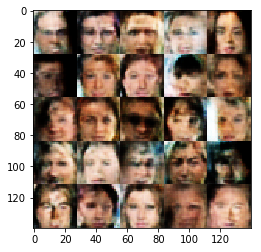

Epoch 1/1... Steps 2610     Discriminator Loss: 0.4600... Generator Loss: 2.3410
Epoch 1/1... Steps 2620     Discriminator Loss: 0.4589... Generator Loss: 1.4838
Epoch 1/1... Steps 2630     Discriminator Loss: 0.2600... Generator Loss: 2.3978
Epoch 1/1... Steps 2640     Discriminator Loss: 1.6309... Generator Loss: 3.1247
Epoch 1/1... Steps 2650     Discriminator Loss: 5.5839... Generator Loss: 5.7362
Epoch 1/1... Steps 2660     Discriminator Loss: 1.5981... Generator Loss: 1.1550
Epoch 1/1... Steps 2670     Discriminator Loss: 1.2226... Generator Loss: 1.3900
Epoch 1/1... Steps 2680     Discriminator Loss: 0.4957... Generator Loss: 1.2454
Epoch 1/1... Steps 2690     Discriminator Loss: 1.2686... Generator Loss: 0.6367
Epoch 1/1... Steps 2700     Discriminator Loss: 1.4677... Generator Loss: 1.3564


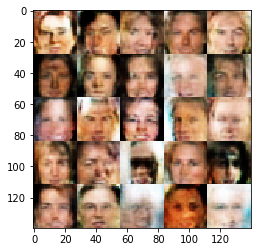

Epoch 1/1... Steps 2710     Discriminator Loss: 0.6882... Generator Loss: 1.0759
Epoch 1/1... Steps 2720     Discriminator Loss: 0.2018... Generator Loss: 2.2042
Epoch 1/1... Steps 2730     Discriminator Loss: 0.8770... Generator Loss: 1.6330
Epoch 1/1... Steps 2740     Discriminator Loss: 1.3132... Generator Loss: 0.3940
Epoch 1/1... Steps 2750     Discriminator Loss: 0.5213... Generator Loss: 1.1392
Epoch 1/1... Steps 2760     Discriminator Loss: 0.9341... Generator Loss: 0.6743
Epoch 1/1... Steps 2770     Discriminator Loss: 1.3553... Generator Loss: 3.3907
Epoch 1/1... Steps 2780     Discriminator Loss: 1.4068... Generator Loss: 0.4182
Epoch 1/1... Steps 2790     Discriminator Loss: 0.3531... Generator Loss: 1.8520
Epoch 1/1... Steps 2800     Discriminator Loss: 0.6999... Generator Loss: 3.5397


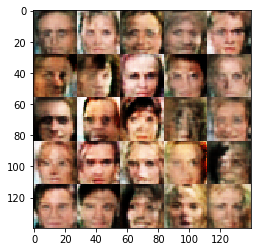

Epoch 1/1... Steps 2810     Discriminator Loss: 0.5279... Generator Loss: 1.2568
Epoch 1/1... Steps 2820     Discriminator Loss: 0.7481... Generator Loss: 0.8335
Epoch 1/1... Steps 2830     Discriminator Loss: 0.6355... Generator Loss: 4.2655
Epoch 1/1... Steps 2840     Discriminator Loss: 0.3084... Generator Loss: 1.7322
Epoch 1/1... Steps 2850     Discriminator Loss: 0.8208... Generator Loss: 0.7887
Epoch 1/1... Steps 2860     Discriminator Loss: 0.3981... Generator Loss: 1.8421
Epoch 1/1... Steps 2870     Discriminator Loss: 0.4746... Generator Loss: 3.3487
Epoch 1/1... Steps 2880     Discriminator Loss: 0.3136... Generator Loss: 1.6014
Epoch 1/1... Steps 2890     Discriminator Loss: 0.1227... Generator Loss: 3.4912
Epoch 1/1... Steps 2900     Discriminator Loss: 0.2843... Generator Loss: 2.2937


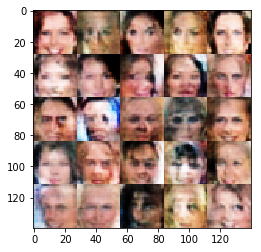

Epoch 1/1... Steps 2910     Discriminator Loss: 0.8890... Generator Loss: 2.0149
Epoch 1/1... Steps 2920     Discriminator Loss: 0.4759... Generator Loss: 1.0587
Epoch 1/1... Steps 2930     Discriminator Loss: 3.1612... Generator Loss: 3.3426
Epoch 1/1... Steps 2940     Discriminator Loss: 1.0068... Generator Loss: 1.1706
Epoch 1/1... Steps 2950     Discriminator Loss: 1.4935... Generator Loss: 0.3607
Epoch 1/1... Steps 2960     Discriminator Loss: 0.2016... Generator Loss: 2.5346
Epoch 1/1... Steps 2970     Discriminator Loss: 0.1369... Generator Loss: 2.4829
Epoch 1/1... Steps 2980     Discriminator Loss: 0.1467... Generator Loss: 2.3948
Epoch 1/1... Steps 2990     Discriminator Loss: 0.0526... Generator Loss: 4.0309
Epoch 1/1... Steps 3000     Discriminator Loss: 1.6647... Generator Loss: 0.6591


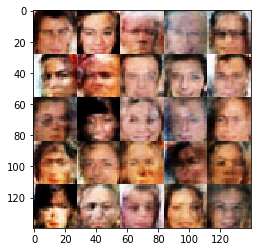

Epoch 1/1... Steps 3010     Discriminator Loss: 0.6999... Generator Loss: 1.0003
Epoch 1/1... Steps 3020     Discriminator Loss: 0.3136... Generator Loss: 3.3643
Epoch 1/1... Steps 3030     Discriminator Loss: 0.0471... Generator Loss: 4.2769
Epoch 1/1... Steps 3040     Discriminator Loss: 1.2259... Generator Loss: 0.5155
Epoch 1/1... Steps 3050     Discriminator Loss: 1.2688... Generator Loss: 0.4964
Epoch 1/1... Steps 3060     Discriminator Loss: 0.9459... Generator Loss: 0.6383
Epoch 1/1... Steps 3070     Discriminator Loss: 0.2949... Generator Loss: 2.5273
Epoch 1/1... Steps 3080     Discriminator Loss: 0.3747... Generator Loss: 1.3992
Epoch 1/1... Steps 3090     Discriminator Loss: 0.5720... Generator Loss: 2.4732
Epoch 1/1... Steps 3100     Discriminator Loss: 0.2823... Generator Loss: 1.6869


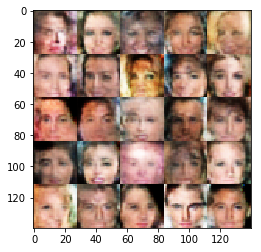

Epoch 1/1... Steps 3110     Discriminator Loss: 0.2406... Generator Loss: 2.0597
Epoch 1/1... Steps 3120     Discriminator Loss: 0.1724... Generator Loss: 2.2070
Epoch 1/1... Steps 3130     Discriminator Loss: 0.1567... Generator Loss: 3.8302
Epoch 1/1... Steps 3140     Discriminator Loss: 0.2042... Generator Loss: 1.9962
Epoch 1/1... Steps 3150     Discriminator Loss: 2.5339... Generator Loss: 4.7456
Epoch 1/1... Steps 3160     Discriminator Loss: 0.0566... Generator Loss: 3.1867


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.